# Семинар 7 - Линейная регрессия

##### Краткий синопсис:
1. Линейная Регрессия
2. RVM 

http://scikit-learn.org/stable/modules/linear_model.html

In [1]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
np.random.seed(42)
warnings.filterwarnings("ignore")

# 1. Линейная регрессия.

## Про сигналы, фильтры и стабильность$^{\mathrm{TM}}$

### Построим сигнал, который представляет собой модулированную синусоиду

In [2]:
a1 = 10.
a2 = 1.
w1 = 1.
w2 = 12.
N = 256

In [3]:
x = np.linspace(-4, 4, N)
f = a1 * np.sin(w1 * x) + a2 * np.sin(w2 * x)

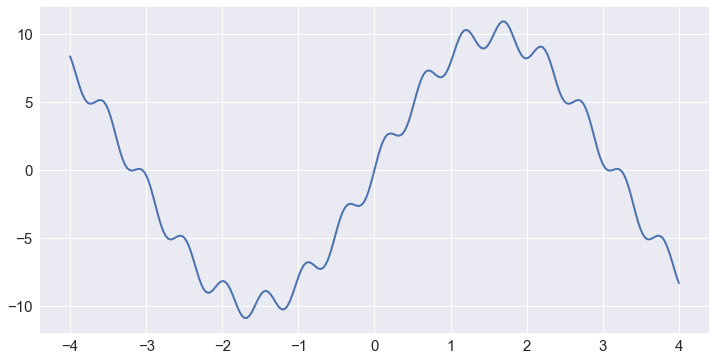

In [4]:
plt.figure(figsize=(12,6))
plt.plot(x, f, linewidth=2)

Сгенерируем оператор, который определяется матрицей $A$ ленточного вида.

Такой оператор соответствует как если бы сигнал обработали moving average, т.е. производит усреднение по некоторому скользящему окну.

In [5]:
A = np.eye(N)
for k in range(1, 15):
    A += np.diag(np.ones(N), k=k)[:N, :N]
    A += np.diag(np.ones(N), k=-k)[:N, :N]

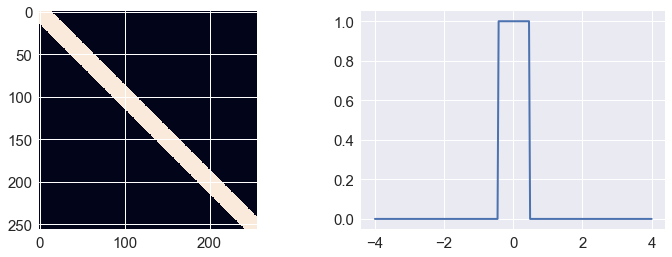

In [6]:
fig, axs = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axs[0].imshow(A)
axs[1].plot(x, A[N // 2,:], linewidth=2)

Сгенерируем выборку $xi$ умножив нашу диагональную матрицу $A$ на наш сигнал $f$.

Т.е. эффективно сгладив сигнал moving average.

In [8]:
sigma = 2
noise = sigma * np.random.randn(N)
xi = np.dot(A, f) + noise

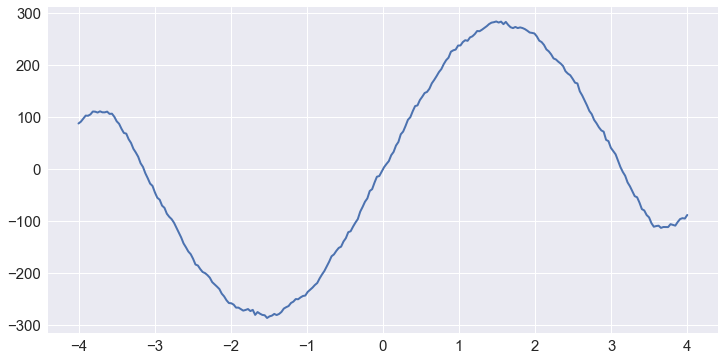

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(x, xi, linewidth=2)

### 1.1 LEAST SQUARES ESTIMATE

Первым делом попробуем восстановить сигнал с помощью LSE, т.е. с помощью метода наименьших квадратов.

$$Af = \xi$$

Матрица псевдорешения(псевдообратная матрица):

$$A^+ = (A^T A)^{-1} A^T$$

Тогда решение можно представить следующим образом:

$$f = A^+ \xi$$

In [11]:
R = np.dot(
        np.linalg.inv(np.dot(A.T, A)),
        A.T
    )
Rxi = np.dot(R, xi)

Text(0.5,1,'Восстановленный сигнала с помощью LSE')

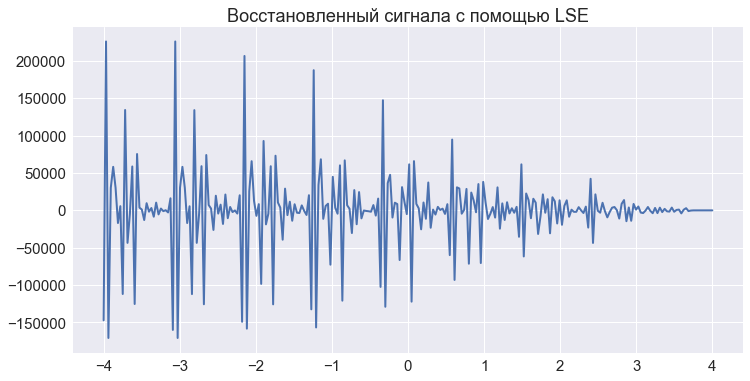

In [12]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi, linewidth=2)
plt.title('Восстановленный сигнала с помощью LSE')

## Что произошло?

Наш вариант реализации псевдообратной является неканоничным и страдает из-за плохих собственных значений.
Поэтому лучше использовать специализированные пакеты, которые более эффективно вычисляют псевдообратные матрицы.

https://en.wikipedia.org/wiki/Generalized_inverse

In [13]:
np.linalg.pinv?

In [14]:
R_pinv = np.linalg.pinv(A)
R_pinv_xi = np.dot(R_pinv, xi)

Text(0.5,1,'Восстановленный сигнал с помощью np.linalg.pinv')

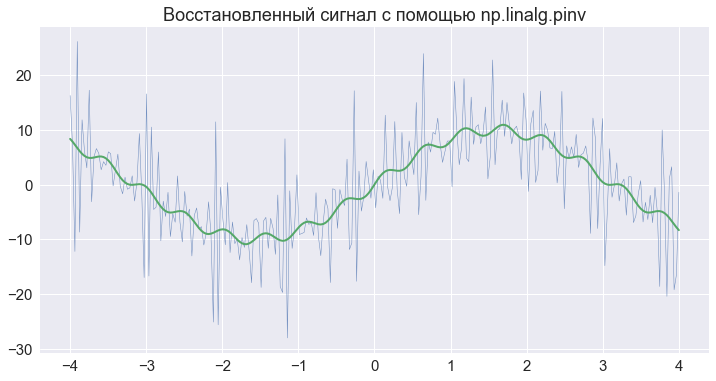

In [15]:
plt.figure(figsize=(12,6))
plt.plot(x, R_pinv_xi, linewidth=0.5, alpha=0.8)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал с помощью np.linalg.pinv')

### NOT QUITE THERE YET. REGULARIZE!

In [17]:
c = 1e-3
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    ) 
Rxi_reg = np.dot(R_reg, xi)

Text(0.5,1,'Восстановленный сигнал при включении регуляризации')

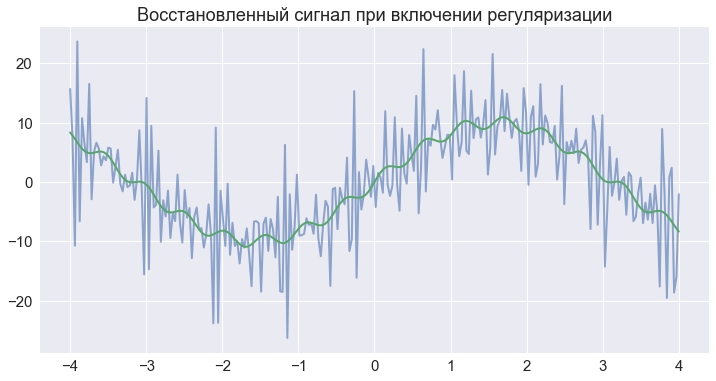

In [18]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

#### Как выбирать коэффициент регуляризации?

In [20]:
reg_coeffs = np.linspace(0.1, 20, 80)
reg_loss = []
for c in reg_coeffs:
    R_reg = np.dot(
            np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
            A.T
        )
    Rxi_reg = np.dot(R_reg, xi)
    loss = np.sum((f - Rxi_reg)**2)
    reg_loss.append(loss)

Text(0.5,1,'MSE в зависимости от коэффициента регуляризации')

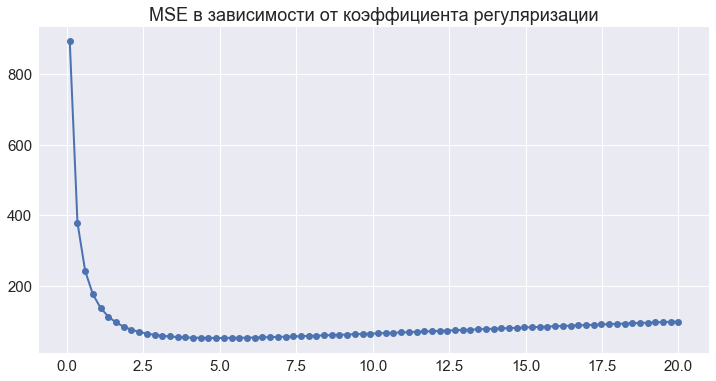

In [21]:
plt.figure(figsize=(12,6))
plt.plot(reg_coeffs, reg_loss, 'o-', linewidth=2)
plt.title('MSE в зависимости от коэффициента регуляризации')

In [22]:
reg_coeffs[np.argmin(reg_loss)]

4.886075949367087

In [23]:
c = 4.886075949367087
R_reg = np.dot(
        np.linalg.inv(np.dot(A.T, A) + c * np.eye(N)),
        A.T
    )
Rxi_reg = np.dot(R_reg, xi)

Text(0.5,1,'Восстановленный сигнал при включении регуляризации')

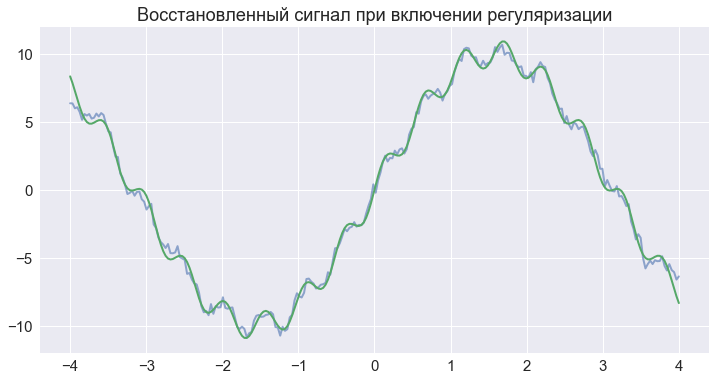

In [24]:
plt.figure(figsize=(12,6))
plt.plot(x, Rxi_reg, linewidth=2, alpha=0.6)
plt.plot(x, f, linewidth=2)
plt.title('Восстановленный сигнал при включении регуляризации')

###  SVD

$$A_{n \times m } = U_{m \times m } \Sigma_{m \times n } V_{n \times n }$$

In [25]:
U, S, V = np.linalg.svd(A)

Text(0.5,1,'Собственные числа оператора A')

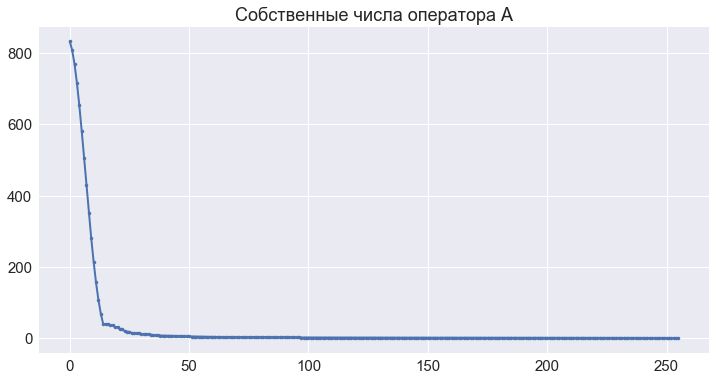

In [26]:
plt.figure(figsize=(12,6))
plt.plot(S**2, '.-', linewidth=2)
plt.title('Собственные числа оператора A')

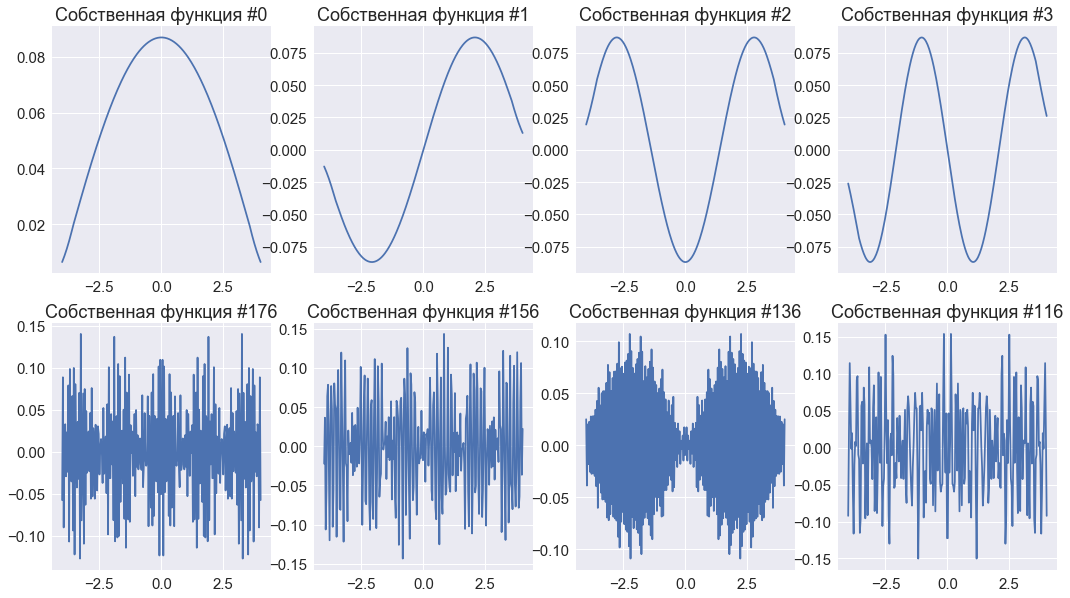

In [27]:
fig, axs = plt.subplots(figsize=(18, 10), ncols=4, nrows=2)
for i in range(4):
    axs[0, i].plot(x, V[i])
    axs[0, i].set_title('Собственная функция #{}'.format(i))
for i in range(4):
    axs[1, i].plot(x, V[N-(4 + i) * 20])
    axs[1, i].set_title('Собственная функция #{}'.format(N-(4 + i) * 20))

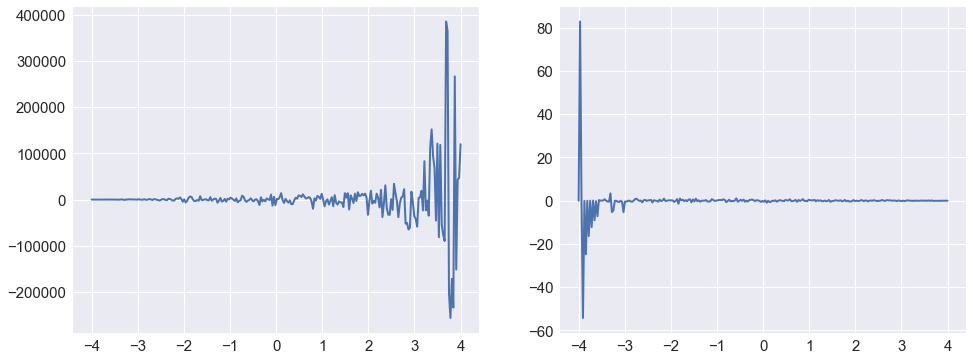

In [28]:
# Отфильтрованный интервал в базисе оператора
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(x, np.dot(V, Rxi), linewidth=2) # <YOUR_CODE>
axs[1].plot(x, np.dot(V, Rxi_reg), linewidth=2) # <YOUR_CODE>

### Переходим к базису оператора A и сделаем все те же самые трюки что делали раньше

Как перейти к базису оператора A имея матрицы $U$, $V$ и $S$?

In [29]:
f_wave = np.dot(V, f) # <YOUR_CODE>
noise_wave = np.dot(V, noise) # <YOUR_CODE>

In [30]:
A_wave = np.diag(S)

In [31]:
xi_wave = np.dot(A_wave, f_wave) + noise_wave

Text(0.5,1,'Отфильтрованный сигнал при переходе ')

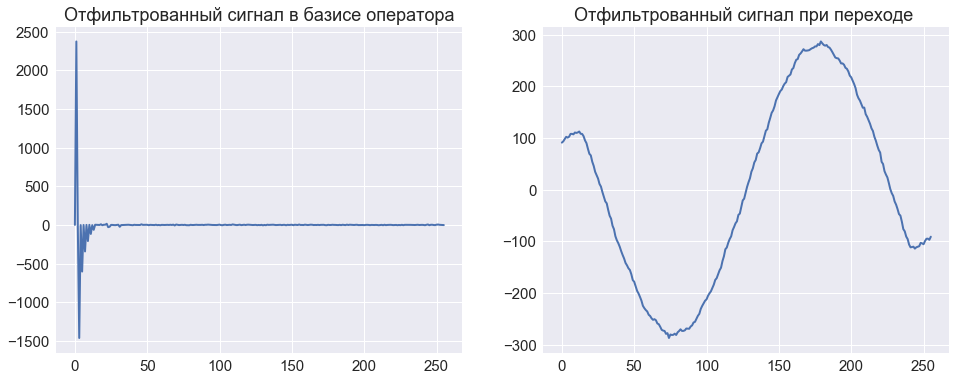

In [32]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)

axs[0].plot(xi_wave, linewidth=2)
axs[0].set_title('Отфильтрованный сигнал в базисе оператора')

# Теперь у нас есть xi_wave -- сигнал в базисе оператора A
# покажем, что это тот самый отфильтрованный сигнал, перейдя обратно в изначальный базис
axs[1].plot(np.dot(V.T, xi_wave), linewidth=2) # <YOUR_CODE>
axs[1].set_title('Отфильтрованный сигнал при переходе ')

In [33]:
R_wave = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave)),
        A_wave.T
)
R_wave_xi = np.dot(R_wave, xi_wave)

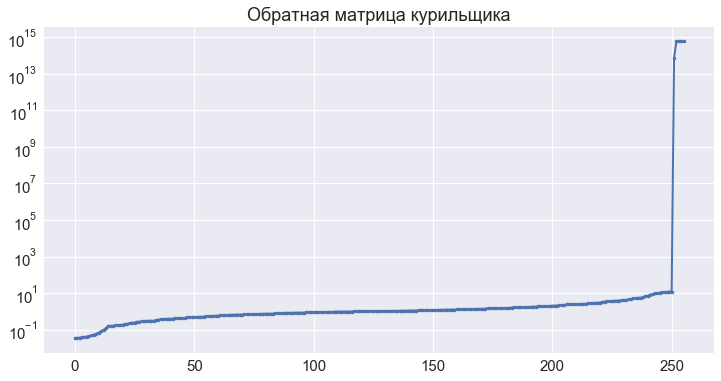

In [34]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_wave), '.-', linewidth=2)
plt.title('Обратная матрица курильщика')
plt.yscale('log')

Text(0.5,1,'Восстановленный сигнал ')

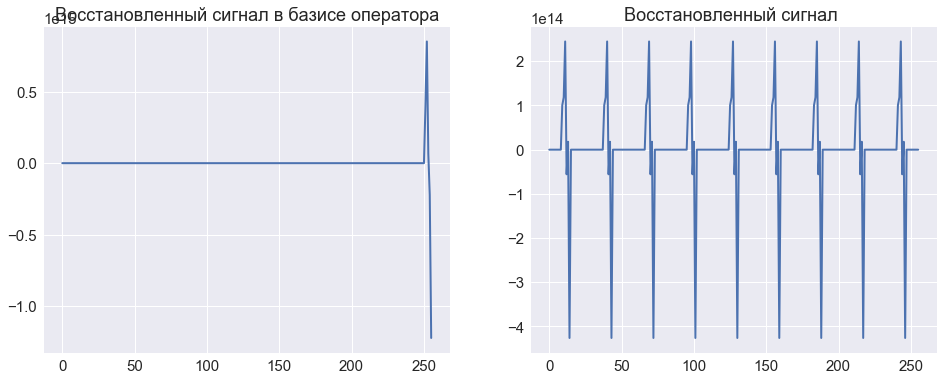

In [35]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(np.dot(V.T, R_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [36]:
R_pinv_wave = np.linalg.pinv(A_wave)
R_pinv_wave_xi = np.dot(R_pinv_wave, xi_wave)

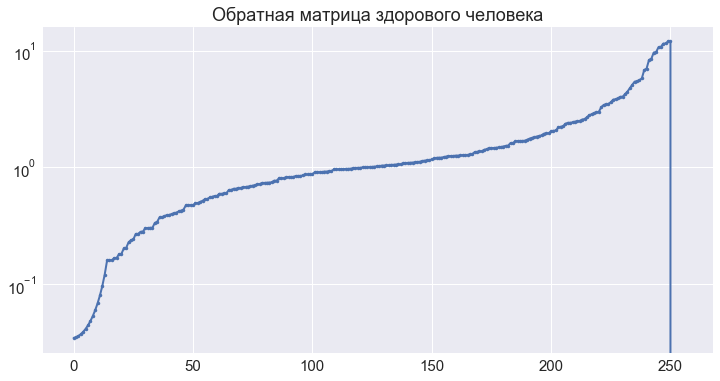

In [37]:
plt.figure(figsize=(12,6))
plt.plot(np.diag(R_pinv_wave), '.-', linewidth=2)
plt.title('Обратная матрица здорового человека')
plt.yscale('log')

Text(0.5,1,'Восстановленный сигнал ')

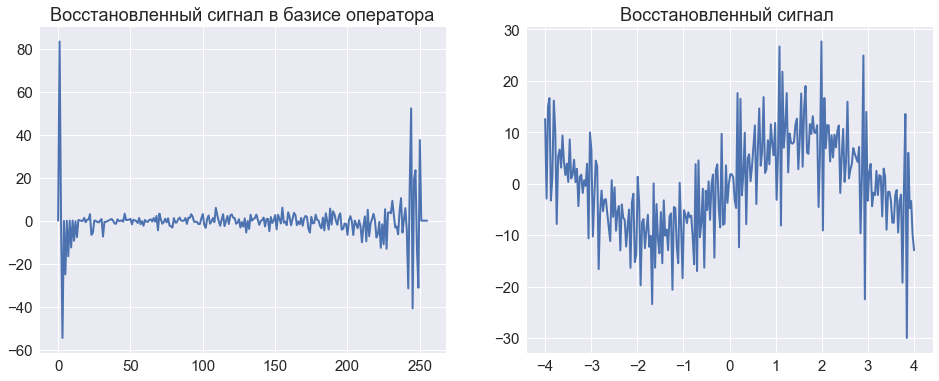

In [38]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_pinv_wave_xi, linewidth=2)
axs[0].set_title('Восстановленный сигнал в базисе оператора')

axs[1].plot(x, np.dot(V.T, R_pinv_wave_xi), linewidth=2)
axs[1].set_title('Восстановленный сигнал ')

In [39]:
c = 5.21
R_wave_reg = np.dot(
        np.linalg.inv(np.dot(A_wave.T, A_wave) + c * np.eye(N)),
        A_wave.T
    )
R_wave_xi_reg = np.dot(R_wave_reg, xi_wave)

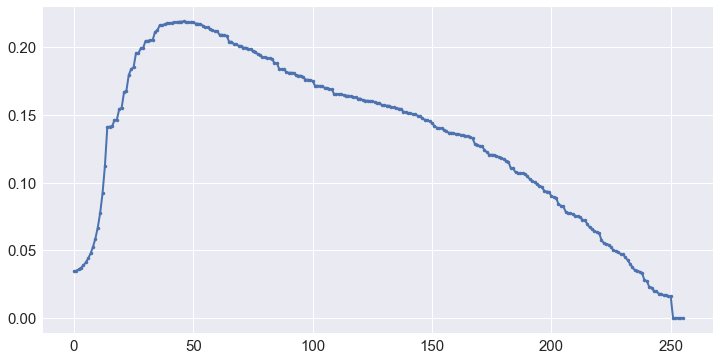

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(np.diag(R_wave_reg), '.-', linewidth=2)

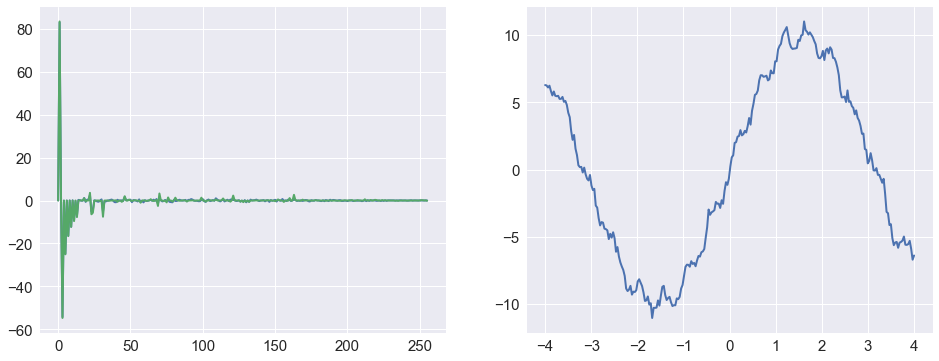

In [41]:
fig, axs = plt.subplots(figsize=(16,6), ncols=2, nrows=1)
axs[0].plot(R_wave_xi_reg, linewidth=2)
axs[0].plot(f_wave, linewidth=2)
axs[1].plot(x, np.dot(V.T, R_wave_xi_reg), linewidth=2)

# A Primer on Bayesian Methods for Multilevel Modeling


https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section4_7-Multilevel-Modeling.ipynb#scrollTo=xn0g05waFP35


http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/

In [154]:
# Import radon data
srrs2 = pd.read_csv('./srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()

RANDOM_SEEDS = [20090425, 19700903]

In [155]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv('./cty.dat')
cty_mn = cty[cty.st=='MN'].copy()
cty_mn['fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [156]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [157]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [158]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = mn_counties.shape[0]
county_lookup = dict(zip(mn_counties, range(counties)))

In [159]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

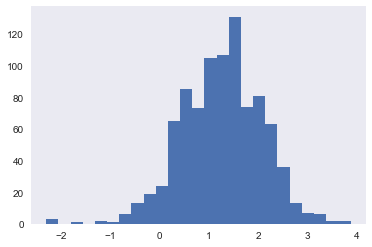

In [160]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25, grid=False);

In [ ]:
def bias_var_decomposition(model, X, y):
    pass

https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section6_3-Model-Selection-and-Validation.ipynb#scrollTo=8q2j7k9Y34mO

In the cross-validation above, notice that the error is high for both very low and very high polynomial values, while training error declines monotonically with degree. The cross-validation error is composed of two components: **bias** and **variance**. When a model is underfit, bias is low but variance is high, while when a model is overfit, the reverse is true.

One can show that the MSE decomposes into a sum of the bias (squared) and variance of the estimator:

$$\begin{aligned}
\text{Var}(\hat{\theta}) &= E[\hat{\theta} - \theta]^2 - (E[\hat{\theta} - \theta])^2 \\
\Rightarrow E[\hat{\theta} - \theta]^2 &= \text{Var}(\hat{\theta}) + \text{Bias}(\hat{\theta})^2
\end{aligned}$$

The training error, on the other hand, does not have this tradeoff; it will always decrease (or at least, never increase) as variables (polynomial terms) are added to the model.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

xvals = np.arange(salmon.spawners.min(), salmon.spawners.max())

fit1 = np.polyfit(salmon.spawners, salmon.recruits, 1)
p1 = np.poly1d(fit1)
axes[0].plot(xvals, p1(xvals))
axes[0].scatter(x=salmon.spawners, y=salmon.recruits)

fit15 = np.polyfit(salmon.spawners, salmon.recruits, 15)
p15 = np.poly1d(fit15)
axes[1].plot(xvals, p15(xvals))
axes[1].scatter(x=salmon.spawners, y=salmon.recruits)

In [ ]:
degrees = np.arange(11)
train_err = np.zeros(len(degrees))
validation_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(xtrain, ytrain, d)

    train_err[i] = rmse(xtrain, ytrain, p)
    validation_err[i] = rmse(xtest, ytest, p)

fig, ax = plt.subplots()

ax.plot(degrees, validation_err, lw=2, label = 'cross-validation error')
ax.plot(degrees, train_err, lw=2, label = 'training error')

ax.legend(loc=0)
ax.set_xlabel('degree of fit')
ax.set_ylabel('rms error')

### Information-theoretic Model Selection

One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. Akaike's Information Criterion (AIC) is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias. 

$$\text{AIC} = −2 \log(L(\theta|data)) + 2K$$

AIC balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

To apply AIC to a model selection problem, we choose the model that has the lowest AIC value.

[AIC can be shown to be equivalent to leave-one-out cross-validation](http://www.jstor.org/stable/2984877).

In [ ]:
aic = lambda rss, n, k: n*np.log(float(rss)/n) + 2*k

In [ ]:
aic_values = np.zeros(len(degrees))
params = np.zeros((len(degrees), len(degrees)))

for i, d in enumerate(degrees):
    p, residuals, rank, singular_values, rcond = np.polyfit(
                                salmon.spawners, salmon.recruits, d, full=True)
    aic_values[i] = aic((residuals).sum(), len(salmon.spawners), d+1)
    params[i, :(d+1)] = p

plt.plot(degrees[1:], aic_values[1:], lw=2)
plt.xlabel('degree of fit')
plt.ylabel('AIC')

For ease of interpretation, AIC values can be transformed into model weights via:

$$w_i = \frac{\exp(-\frac{1}{2} \delta \text{AIC}_i)}{\sum_{m=1}^M \exp(-\frac{1}{2} \delta \text{AIC}_m)}$$

In [ ]:
aic_trans = np.exp(-0.5*aic_values)
aic_probs = aic_trans/aic_trans.sum()
aic_probs.round(2)

## K-fold Cross-validation

In **k-fold cross-validation**, the training set is split into *k* smaller sets. Then, for each of the k "folds":

1. trained model on *k-1* of the folds as training data
2. validate this model the remaining fold, using an appropriate metric

The performance measure reported by k-fold CV is then the average of the *k* computed values. This approach can be computationally expensive, but does not waste too much data, which is an advantage over having a fixed test subset.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
RNG = np.random.RandomState(42)

nfolds = 3
fig, axes = plt.subplots(1, nfolds, figsize=(14,4))
kf = KFold(n_splits=nfolds, shuffle=True, random_state=RNG)
for i, fold in enumerate(kf.split(salmon.values)):
    training, validation = fold
    y, x = salmon.values[training].T
    axes[i].plot(x, y, 'ro')
    y, x = salmon.values[validation].T
    axes[i].plot(x, y, 'bo')
plt.tight_layout()

In [ ]:
k = 5
degrees = np.arange(1,8)
k_fold_err = np.empty(len(degrees))

for i, d in enumerate(degrees):
    
    error = np.empty(k)
    
    #for j, fold in enumerate(gen_k_folds(salmon, k)):
    for j, fold in enumerate(KFold(n_splits=k, random_state=RNG).split(salmon.values)):

        training, validation = fold
        
        y_train, x_train = salmon.values[training].T
        y_test, x_test = salmon.values[validation].T
        
        p = np.polyfit(x_train, y_train, d)
        
        error[j] = rmse(x_test, y_test, p)

    k_fold_err[i] = error.mean()
        

fig, ax = plt.subplots()

ax.plot(degrees, k_fold_err, lw=2)
ax.set_xlabel('degree of fit')
ax.set_ylabel('average rms error')

https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section4_7-Multilevel-Modeling.ipynb

## Predictive Information Criteria

https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section4_9-Model-Comparison.ipynb#scrollTo=4G62zkf_38kw


Measures of predictive accuracy are called information criteria, and are comprised of the log-predictive density of the data given a point estimate of the fitted model multiplied by −2 (i.e. the deviance):

$$−2 \log[p(y | \hat{\theta})]$$

Clearly, the expected accuracy of a fitted model’s predictions of future data will generally be lower than the accuracy of the model’s predictions for observed data, even though the parameters in the model happen to be sampled from the specified prior distribution.

Why are we interested in prediction accuracy?

1. to quantify the performance of a model
2. to perform model selection 

By model selection, we may not necessarily want to choose one model over another, but we might want to put different models on the same scale. The advantage if information-theoretic measures is that candidate models do not need to be nested; even models with completely different parameterizations can be used to predict the same measurements.

Note that when candidate models have the same number of parameters, one can compare their best-fit log predictive densities directly, but when model dimensions differ, one has to make an adjustment for the tendency of a larger model to fit data better.

### AIC and DIC

One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. Akaike's Information Criterion (AIC) is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias.

$$\text{AIC} = −2 \log(L(\theta|data)) + 2K$$

AIC balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

A limitation of AIC for Bayesian models is that it cannot be applied to hierarchical models (or any models with random effects), as counting the number of parameters in such models is problematic. A more Bayesian version of AIC is called the deviance information criterion (DIC), and replaces the fixed parameter penalty with an estimate of the effective number of parameters.

$$p_{DIC} = 2\left(\log p(y | E[\theta | y]) - E_{post}[\log p(y|\theta)] \right)$$

where the second term is an average of $\theta$ over the posterior distribution:

$$\hat{p}_{DIC} = 2\left(\log p(y | E[\theta | y]) - \frac{1}{M} \sum_{j=1}^{M}\log p(y|\theta^{(j)}) \right)$$

DIC is computed as:

$$\text{DIC} = -2 \log p(y | E[\theta | y]) + 2p_{DIC}$$

Though this is an improvement over AIC, DIC is still not fully Bayesian, as it relies on a point estimate of the model rather than using the full posterior. As a result, it can be unstable for hierarchical models, sometimes producing estimates of effective number of parameters that is negative.

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

The computed log pointwise predictive density is:

$$lppd_{comp} = \sum_{i=1}^N \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)}) \right)$$

The complexity adjustment here is as follows:

$$p_{WAIC} = 2\sum_{i=1}^N \left[ \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)})\right)  - \frac{1}{M} \sum_{j=1}^M \log p(y_i | \theta^{(j)})  \right]$$

so WAIC is then:

$$\text{WAIC} = -2(lppd) + 2p_{WAIC}$$

The adjustment is an approximation to the number of unconstrained parameters in the model (0=fully constrained, 1=no constraints). In this sense, WAIC treats the effective number of paramters as a random variable.

WAIC averages over the posterior distribution, and therefore is more reliable for a wider range of models.

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. 

The estimate of out-of-sample predictive fit from applying LOO cross-validation to a Bayesian model is:

$$lppd_{loo} = \sum_{i=1}^N \log p_{post(-i)}(y_i) =  \sum_{i=1}^N \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i| \theta^{(is)})\right)$$

so, each prediction is conditioned on $N-1$ data points, which induces an underestimation of the predictive fit for smaller $N$. The resulting estimate of effective samples size is:

$$p_{loo} = lppd - lppd_{loo}$$

As mentioned, using cross-validation for a Bayesian model, fitting $N$ copies of the model under different subsets of the data is computationally expensive. However, Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

This involves estimating the importance sampling LOO predictive distribution

$$p(\tilde{y}_i | y_{-i}) \approx \frac{\sum_{s=1}^S w_i(\theta^{(s)}) p(\tilde{y}_i|\theta^{(s)})}{\sum_{s=1}^S w_i(\theta^{(s)})}$$

where the importance weights are:

$$w_i(\theta^{(s)}) = \frac{1}{p(y_i | \theta^{(s)})} \propto \frac{p(\theta^{(s)}|y_{-i})}{p(\theta^{(s)}|y)}$$

The predictive distribution evaluated at the held-out point is then:

$$p(y_i | y_{-i}) \approx \frac{1}{\frac{1}{S} \sum_{s=1}^S \frac{1}{p(y_i | \theta^{(s)})}}$$

However, the posterior is likely to have a smaller variance and thinner tails than the LOO posteriors, so this approximation induces instability due to the fact that the importance ratios can have high or infinite variance.
To deal with this instability, a generalized Pareto distribution fit to the upper tail of the distribution of the importance ratios can be used to construct a test for a finite importance ratio variance. If the test suggests the variance is infinite then importance sampling is halted.

https://colab.research.google.com/drive/1jay1jkYKraGwcrV8P8e3rDeADNK_2Rku

# RVM

### Relevance Vector Machine

Метод релевантных векторов -- линейная регрессия под амфетамином с дисперсиями и байесовскими методами.

Задача ставится классическим образом: построить модель зависимости для выборки вида $(X, y) = \{ x_i, y_i \}_{i=1}^N$. Причём мы

$$f(x_i) = w^T x_i$$

#### Вероятностная интерпретация линейной регрессии

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) = \prod\limits_{i=1}^{N} \mathcal{N}(y_i | w^T x_i, \sigma^2) \$$

$$= \frac{1}{\sigma^n (2 \pi)^{n/2}} \exp \left( - \frac{\sum\limits_{i=1}^{N} (y_i - w^T x_i)^2}{2 \sigma^2} \right)$$

Переходим к лагорифму:

$$\log p(y|X, w) = -\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 \rightarrow \max_{w}$$



#### Добавление регуляризации с точки зрения байесовских методов

$$p(y|X, w) = \prod\limits_{i=1}^{N} p(t_i|x_i, w) p(w), ~~~ p(w) = \mathcal{N}(w | 0, \alpha^{-1})$$


$$-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{N}\left(y_i - w^T x_i\right)^2 - \frac{\alpha}{2} ||w||_2^2 \rightarrow \max_{w}$$

Другими словами, l2-регуляризация эквивалентна тому что мы вешаем на веса априорную плотность.



Минусы: \sigma^2$ и $\alpha$ одни для всех признаков и фиксированы(нужна кросс-валидация);

### RVR
или почему бы нам не добавить распределение на параметры распределения параметров распределения?

$$p(w|\alpha) = \mathcal{N}(0, A^{-1}),~~~A=\mathrm{diag}(\alpha_1, \dots, \alpha_m)$$

Тогда используя сложную математику(см. [1]) можно придумать как обучать такую модель где для каждого признака будет своя собственная дисперсия, которая подбирается автоматически.

[1] http://www.machinelearning.ru/wiki/images/4/43/BayesML-2007-textbook-2.pdf

[2] http://www.machinelearning.ru/wiki/index.php?title=RVM

In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [43]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
from skbayes.rvm_ard_models import RVR
from sklearn.linear_model import LinearRegression
N = 200

In [45]:
x = np.linspace(-5, 5, N)
X = np.vstack([
    x, 
    np.cos(x),
    np.random.randn(N) / 10,
    np.random.randn(N) / 10,
    np.random.randn(N) / 10
]).T
Y = 10 * np.sinc(x) + np.random.randn(N)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5)

Y_test = Y_test[np.argsort(X_test[:, 0])]
X_test = X_test[np.argsort(X_test[:, 0])]

In [46]:
rvm = RVR(kernel='linear')
rvm.fit(X_train, Y_train)

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
Y_pred_rvm, Y_pred_std = rvm.predict_dist(X_test)
Y_pred_lr = lr.predict(X_test)

mean_squared_error(Y_pred_rvm, Y_test), mean_squared_error(Y_pred_lr, Y_test)

(7.538405137755741, 7.951125110054416)

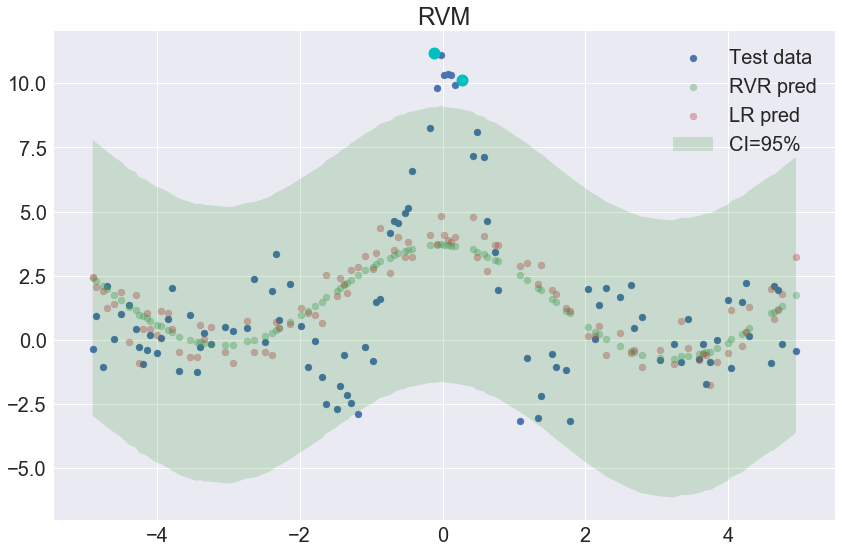

In [48]:
plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "Test data")
plt.scatter(X_test[:, 0], Y_pred_rvm, label = "RVR pred", alpha=0.4)
plt.scatter(X_test[:, 0], Y_pred_lr, label = "LR pred", alpha=0.4)
plt.fill_between(X_test[:, 0], 
                 Y_pred_rvm - 2 * np.sqrt(Y_pred_std), 
                 Y_pred_rvm + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.plot(rvm.relevant_vectors_[:, 0], Y_train[rvm.active_], "co", markersize = 12)
plt.legend()
plt.title("RVM")
plt.show()

### Bias-Variance decomposition

$$\bar{y} = \frac{1}{N} \sum \hat{y}_i$$

$$bias^2=MSE(y, \bar{y})$$

$$variance=\frac{1}{N} \sum MSE(\hat{y}_i, \bar{y})$$

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from tqdm import tqdm

In [50]:
bias_rvr = []
variance_rvr = []
error_rvr = []

bias_lr = []
variance_lr = []
error_lr = []

degrees = np.arange(1, 10)
resamples = 20

for degree in tqdm(degrees):
    
    Y_preds_rvr = []
    Y_preds_lr = []
    for _ in range(resamples):
        X_train_resample, Y_train_resample = resample(X_train, Y_train)
        rvm = RVR(kernel='poly', degree=degree).fit(X_train_resample, Y_train_resample)
        Y_pred_rvr = rvm.predict(X_test)
        Y_preds_rvr.append(Y_pred_rvr)
        
        lr = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                       ('linear', LinearRegression(fit_intercept=False, n_jobs=-1))])
        lr.fit(X_train_resample, Y_train_resample)
        Y_pred_lr = lr.predict(X_test)
        Y_preds_lr.append(Y_pred_lr)

        
    Y_preds_rvr = np.array(Y_preds_rvr)
    bias_rvr.append(
        ((Y_preds_rvr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_rvr.append(
        ((Y_preds_rvr - Y_preds_rvr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_rvr.append(
        ((Y_preds_rvr - Y_test)**2).mean(axis=1).mean()
    )
    
    Y_preds_lr = np.array(Y_preds_lr)
    bias_lr.append(
        ((Y_preds_lr.mean(axis=0) - Y_test)**2).mean()
    )
    variance_lr.append(
        ((Y_preds_lr - Y_preds_lr.mean(axis=0))**2).mean(axis=1).mean()
    )
    error_lr.append(
        ((Y_preds_lr - Y_test)**2).mean(axis=1).mean()
    )
    
bias_rvr = np.array(bias_rvr)
variance_rvr = np.array(variance_rvr)
error_rvr = np.array(error_rvr)

bias_lr = np.array(bias_lr)
variance_lr = np.array(variance_lr)
error_lr = np.array(error_lr)

  0%|          | 0/9 [00:00<?, ?it/s]/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function pinvh is deprecated; sklearn.utils.extmath.pinvh was deprecated in version 0.19 and will be removed in 0.21. Use scipy.linalg.pinvh instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function pinvh is deprecated; sklearn.utils.extmath.pinvh was deprecated in version 0.19 and will be removed in 0.21. Use scipy.linalg.pinvh instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/acappello/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function pinvh is deprecated; sklearn.utils.extmath.pinvh was deprecated in version 0.19 and will be removed in 0.21. Use scipy.linalg.pinvh instead.
  warnings.warn(msg, category=DeprecationWarning)
 33%|███▎      | 3/9 [00:05<00:09,  1.59s/

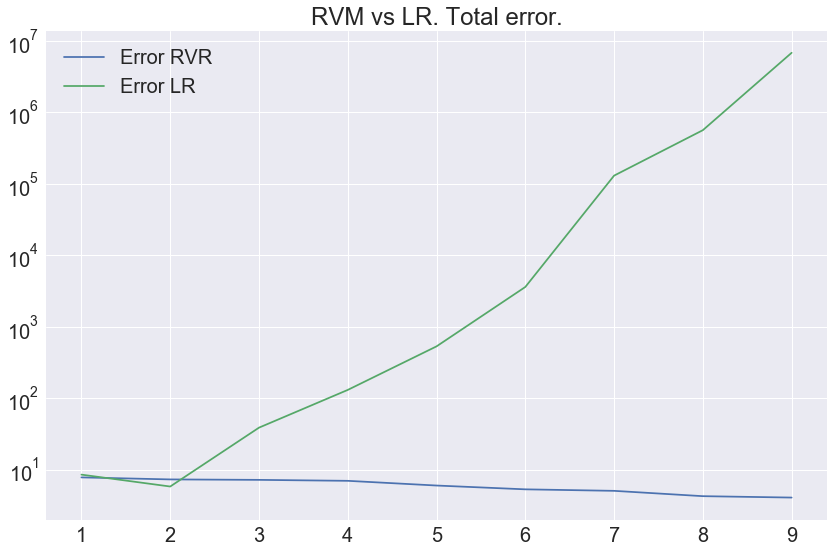

In [51]:
plt.figure(figsize = (14, 9))
plt.plot(degrees, error_rvr, label='Error RVR')
plt.plot(degrees, error_lr, label='Error LR')
plt.yscale('log')
plt.legend()
plt.title("RVM vs LR. Total error.")
plt.show()

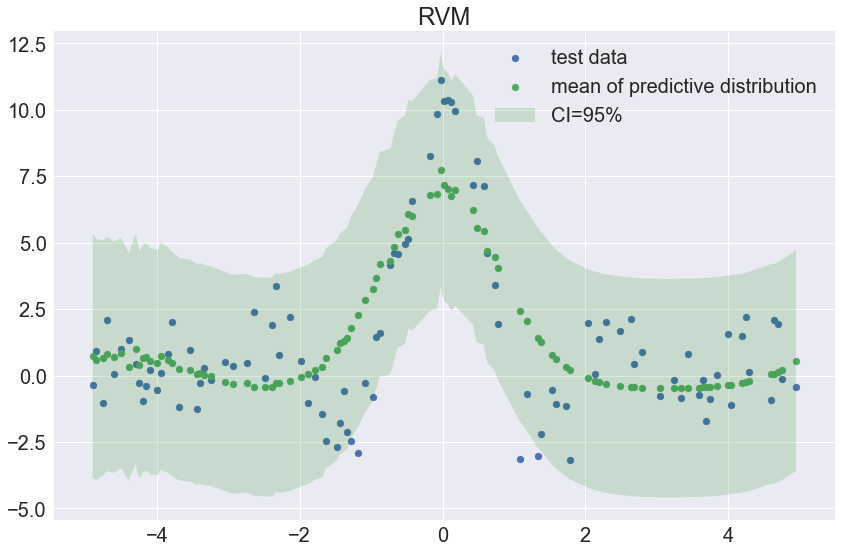

In [52]:
rvm = RVR(kernel='poly', degree=9).fit(X_train, Y_train)
Y_pred, Y_pred_std = rvm.predict_dist(X_test)

plt.figure(figsize = (14, 9))
plt.scatter(X_test[:, 0], Y_test, label = "test data")
plt.scatter(X_test[:, 0], Y_pred, label = "mean of predictive distribution")
plt.fill_between(X_test[:, 0], 
                 Y_pred - 2 * np.sqrt(Y_pred_std), 
                 Y_pred + 2 * np.sqrt(Y_pred_std), 
                 facecolor='g', alpha=0.15, label='CI=95%')
plt.legend()
plt.title("RVM")
plt.show()

# Gaussian Processes

## План

  * Напишем свой простейший GP;
  * Посмотрим на библиотеку `GPy`;
  * С помощью `GPytorch` научимся использовать Scalable GP;
  * Научимся объединять Deep Learning с GP.
  

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
EPS = 1e-10
sns.set()
warnings.filterwarnings("ignore")

def plot_gp(X_train, y_train, X_test, samples, mu, std):
    plt.figure(figsize=(12, 12))


    plt.plot(X_test, samples.T)

    plt.fill_between(X_test.ravel(), 
                     mu.ravel() - 2 * std.ravel(), 
                     mu.ravel() + 2 * std.ravel(), alpha=0.3)

    plt.plot(X_test, mu, 'r--', lw=2, label='Mean of GP')
    
    plt.scatter(X_train, y_train, s=30, label='Original data')

    plt.title('GP')

    plt.legend()

    plt.show()

## Распределения: совместные, условные, частные

Совместное распределение:

$$(x, y) \sim \mathcal{N}\left(\mu, \Sigma\right), ~\mu = [\mu_1, \mu_2], ~~\Sigma=\begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{11}^T & \Sigma_{22} \end{bmatrix}$$

Частное:

$$x \sim  \mathcal{N}(\mu_1, \Sigma_{11})$$


Условное:

$$ (x | y) \sim \mathcal{N}(\mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(y - \mu_2), \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{12}^T)$$

In [56]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[2., 1.5], 
                     [1.5, 2.]])
}

##### Совместное и частные распределения:

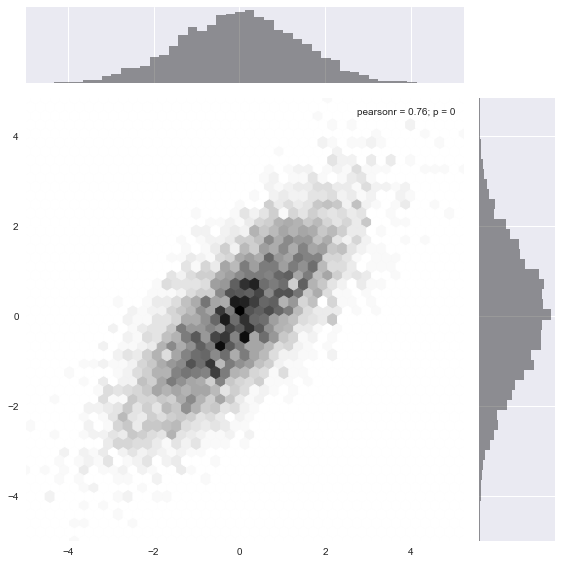

In [57]:
X = np.random.multivariate_normal(size=5000, **parameters)
sns.jointplot(x=X[:, 0], y=X[:, 1], kind="hex", color="k", size=8);

##### Условные распределения:

In [58]:
y = np.linspace(-5, 5, 1000)

In [59]:
mu = parameters['mean'][0] + parameters['cov'][0, 1] * (y - parameters['mean'][1]) / parameters['cov'][1, 1]

var = parameters['cov'][0, 0] - parameters['cov'][0, 1]**2 / parameters['cov'][1, 1]

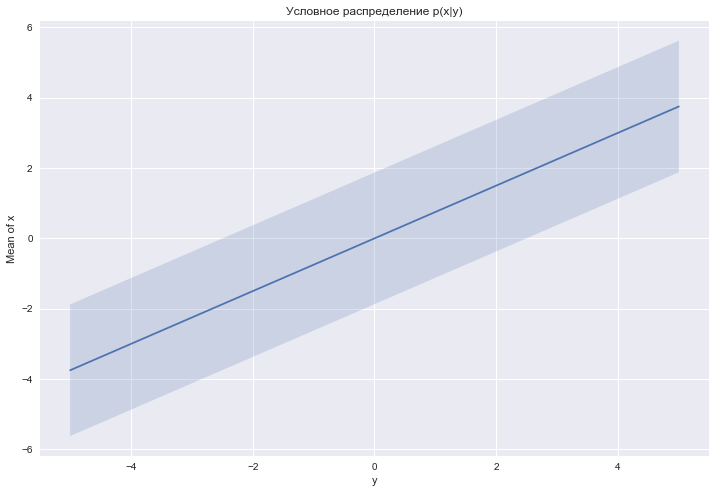

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(y, mu)
plt.fill_between(y, mu - 2 * np.sqrt(var), mu + 2 * np.sqrt(var), alpha=0.2)
plt.title('Условное распределение p(x|y)')
plt.ylabel('Mean of x')
plt.xlabel('y')
plt.show()

### Ядра и, в частности, ~~пушечные~~ гауссовы

$$\mathrm{kern}: X \times X \rightarrow \mathbb{R} $$

Ядро это функция, которая отображает декартово произведение некоторого пространства с самим собой на действительную ось.

Больше инфы про ядра: http://www.machinelearning.ru/wiki/index.php?title=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D1%8F%D0%B4%D1%80%D0%B0

#### Гауссово ядро

$$\mathrm{kern}(x, y) \sim \exp\left( -\frac{||x - y||_2}{2 \sigma^2} \right)$$

In [61]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma
    def __call__(self, x_train, x_test):
        # l2-норма между матрицами x_train[N, K] y_train[M, K]
        # Выходом должна быть матрица [N, M]
        dist = (np.sum(x_train**2, 1)[:, None] + 
                np.sum(x_test**2, 1)[None, :] - 
                2 * x_train.dot(x_test.T)) 
        k = np.exp(- dist / self.sigma**2 / 2)
        return k

### Причём здесь гауссовы процессы?

Пусть у нас есть выборка $X_{train}, y_{train}$ и есть $X_{test}$ для которых мы хотим построить вероятностную модель для $y_{test}$. А ещё мы выбрали некоторое ядро $\mathrm{kern}(\cdot, \cdot)$.

Тогда гауссова регрессия(гауссов процесс) записывается следующим образом:

$$p(X_{test}, y_{test}, X_{train}, y_{train}) = \mathcal{N}\left( 0 , \begin{bmatrix}K + \sigma^2 I & K_* \\ K_*^T & K_{**} \end{bmatrix} \right), $$

где

$$K = \mathrm{kern}(X_{train}, X_{train})$$

$$K_{*} = \mathrm{kern}(X_{train}, X_{test})$$

$$K_{**} = \mathrm{kern}(X_{test}, X_{test})$$

Т.е. матрица ковариаций это матрица ядра. Как мы увидим дальше, выбор ядра __очень важен__ и зависит от задачи.

Тогда наша задача это найти следующее распределение:

$$p(y_{test} | X_{test}, X_{train}, y_{train}) \sim \mathcal{N}\left(K_{*}^T (K + \sigma^2 I)^{-1} y_{train}, K_{**} - K_{*} (K + \sigma^2 I)^{-1} K_{*}^T\right)$$

In [62]:
# Noiseless training data
X_train = np.linspace(-5, 1, 40).reshape(-1, 1)
y_train = np.sin(2 * X_train) + np.random.randn(*X_train.shape) / 2 + X_train / 2

In [63]:
N = 1000
X_test = np.linspace(-6, 12, N).reshape(-1, 1)

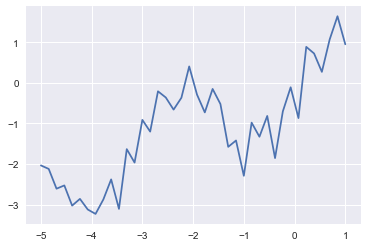

In [64]:
plt.plot(X_train.ravel(), y_train.ravel())

### Какое сейчас время? Время Гауссовой Регрессии!

In [67]:
class GaussianRegression:
    def __init__(self, kernel, X, y, noise=EPS):
        self.kernel = kernel
        self.X_train = X
        self.y_train = y
        self.noise = noise
        
        self.K_train = self.kernel(self.X_train, self.X_train)
        self.L_train = np.linalg.cholesky(self.K_train + self.noise * np.eye(len(X_train)))
        self.K_inv = np.linalg.pinv(self.K_train + self.noise * np.eye(len(X_train)))
    
    def predict(self, X_test):
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test) # <YOUR CODE>
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train)) # <YOUR CODE>
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test) # <YOUR CODE>
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test)) # <YOUR CODE>
        
        # std
        std = np.sqrt(np.diag(cov))
        
        return mu.reshape((len(X_test), -1)), std.reshape((len(X_test), -1))
    
    def sample(self, X_test, n=1):
        # copy-paste code above
        
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        samples = np.random.multivariate_normal(size=n, mean=mu.ravel(), cov=cov)
        
        return samples.T

In [68]:
kernel = GaussianKernel(1.)

In [69]:
gregressor = GaussianRegression(kernel=kernel, X=X_train, y=y_train, noise=1e-3)

In [70]:
mu, std = gregressor.predict(X_test)
samples = gregressor.sample(X_test, n=3).T

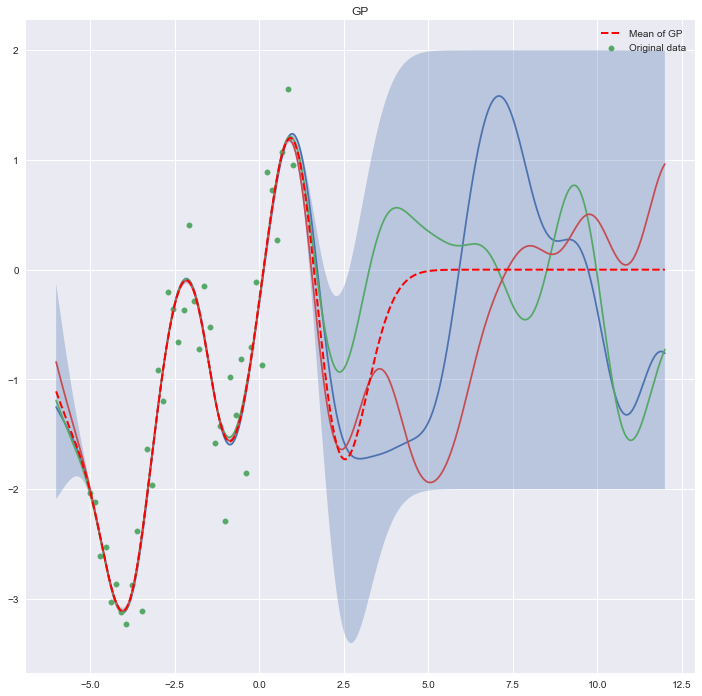

In [71]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)

## GPy

Чтобы не прогать самим и не делать кучу ошибок, лучше использовать готовые решения :)


In [72]:
import GPy

In [73]:
kern = GPy.kern.RBF(input_dim=1, lengthscale=1., variance=1.)

{'covariance': [[<matplotlib.lines.Line2D at 0x7fa7e085b940>]]}

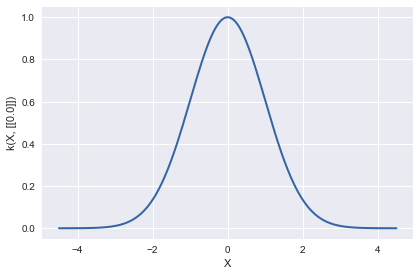

In [74]:
kern.plot()

In [75]:
# нормальные ребята используют для регрессии GPRegression
# clf=GPy.models.GPRegression(X_train, y_train, kern)

In [76]:
# но нам и так нормально
clf=GPy.core.GP(X=X_train, 
                Y=y_train, 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1e-2))

In [77]:
clf.optimize(messages=True, optimizer='scg')

In [78]:
mu, cov = clf.predict(X_test, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=3, mean=mu.ravel(), cov=cov)

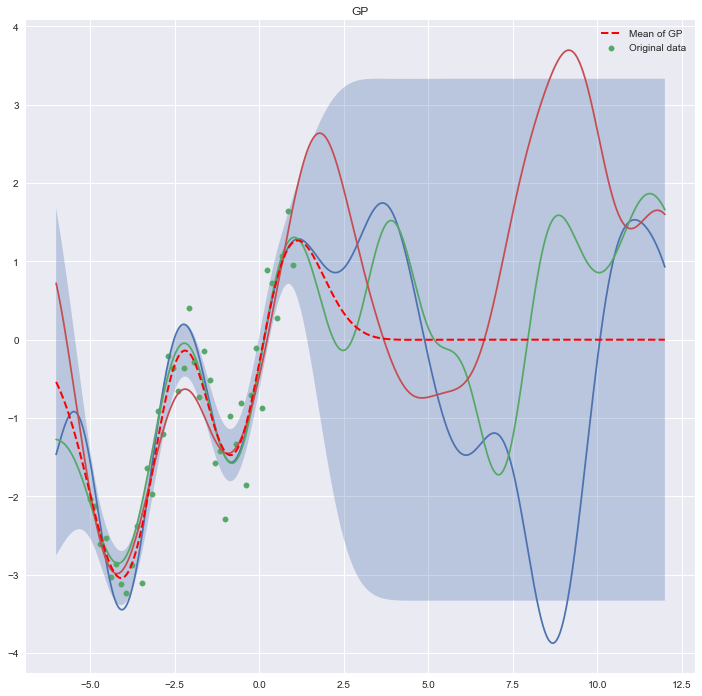

In [79]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)

### MOAR KERNELS

In [80]:
kern = GPy.kern.Cosine(input_dim=1, variance=2.) + GPy.kern.Linear(input_dim=1)# * GPy.kern.RBF(input_dim=1)

{'covariance': [[<matplotlib.lines.Line2D at 0x7fa7e8b1e6a0>]]}

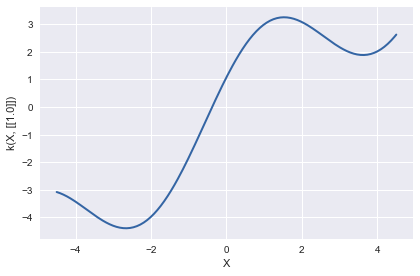

In [81]:
kern.plot()

In [82]:
clf=GPy.core.GP(X=X_train, 
                Y=y_train, 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1.))

In [83]:
clf.optimize(messages=True, optimizer='scg')

In [84]:
mu, cov = clf.predict(X_test, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=10, mean=mu.ravel(), cov=cov)

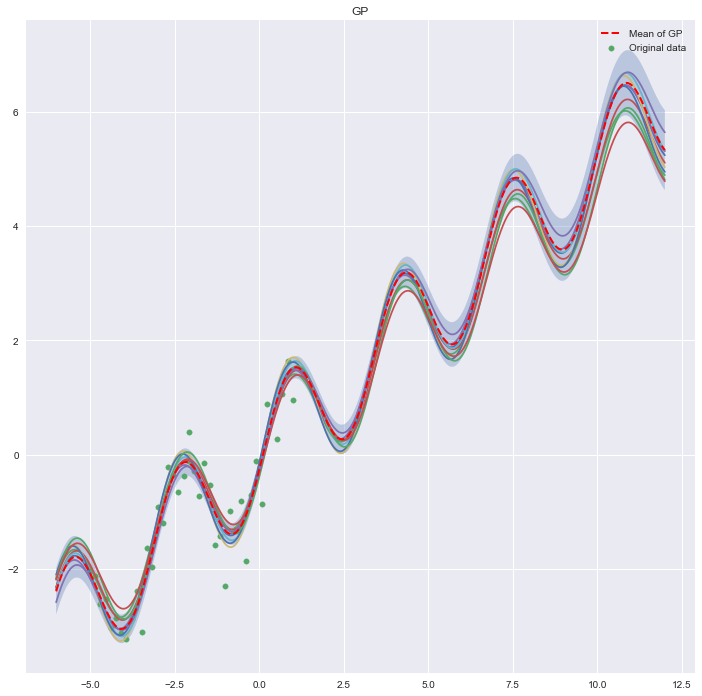

In [85]:
plot_gp(X_train=X_train, y_train=y_train, 
        X_test=X_test, samples=samples, mu=mu, std=std)